In [270]:
import pandas as pd
import numpy as np
import json
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Carga de Datos y Acumulación por Día

In [271]:
folders = ('01-10-19_PT5M','02-10-19_PT5M','05-10-19_PT5M','08-10-19_PT5M')
assets = pd.read_csv('southcentral-asset.csv',sep=';')
datosNTO={}

for i,r in assets.iterrows():
    #print(r.Name)
    ultimoMin = 0
    for j in np.arange(0,len(folders)):
        with open(folders[j]+'/'+r.File, 'r') as f:
            datastore = json.load(f)
            #print('File readed:'+folders[j]+'/'+r.File)
        #tempCPU = pd.DataFrame(datastore["value"][0]["metricValues"])
        #tempNTI = pd.DataFrame(datastore["value"][1]["metricValues"])
        tempNTO = pd.DataFrame(datastore["value"][2]["metricValues"])
        tempMin = np.arange(ultimoMin,ultimoMin+(tempNTO.shape[0]*5),step=5)
        #tempCPU['minute'] = tempMin
        #tempNTI['minute'] = tempMin
        tempNTO['minute'] = tempMin
        ultimoMin = tempMin[len(tempMin)-1]+5
        #print(ultimoMin)
        #tempCPU = tempCPU.dropna(axis=0,how='any')
        #tempNTI = tempNTI.dropna(axis=0,how='any')
        tempNTO = tempNTO.dropna(axis=0,how='any')
        if r.Name in datosNTO:
            #datosCPU[r.Name] = datosCPU[r.Name].append(tempCPU)
            #datosNTI[r.Name] = datosNTI[r.Name].append(tempNTI)
            datosNTO[r.Name] = datosNTO[r.Name].append(tempNTO)
        else:
            #datosCPU[r.Name] = tempCPU
            #datosNTI[r.Name] = tempNTI
            datosNTO[r.Name] = tempNTO

In [272]:
accumNTO={}
for i,r in assets.iterrows():
    for d in np.arange(1,11):
        temp = datosNTO[r.Name][(datosNTO[r.Name]['minute'] >= ((d-1)*1440)) & (datosNTO[r.Name]['minute'] < (d*1440))]
        sumx = temp.apply(np.sum,axis= 0)
        accumNTO[str(d)+'-'+r.Name] = pd.DataFrame(sumx[1:5])

In [273]:
def obtenerDatosAcumulados(nombreEmpresa):
    total = np.array([[1,accumNTO['1-'+nombreEmpresa].transpose()['total'][0]]])
    total = np.append(total, [[2,accumNTO['2-'+nombreEmpresa].transpose()['total'][0]]],axis=0)
    total = np.append(total, [[3,accumNTO['3-'+nombreEmpresa].transpose()['total'][0]]],axis=0)
    total = np.append(total, [[4,accumNTO['4-'+nombreEmpresa].transpose()['total'][0]]],axis=0)
    total = np.append(total, [[5,accumNTO['5-'+nombreEmpresa].transpose()['total'][0]]],axis=0)
    total = np.append(total, [[6,accumNTO['6-'+nombreEmpresa].transpose()['total'][0]]],axis=0)
    total = np.append(total, [[7,accumNTO['7-'+nombreEmpresa].transpose()['total'][0]]],axis=0)
    total = np.append(total, [[8,accumNTO['8-'+nombreEmpresa].transpose()['total'][0]]],axis=0)
    total = np.append(total, [[9,accumNTO['9-'+nombreEmpresa].transpose()['total'][0]]],axis=0)
    total = np.append(total, [[10,accumNTO['10-'+nombreEmpresa].transpose()['total'][0]]],axis=0)
    acumm = pd.DataFrame(total,columns=['dia','acumulado'])
    acumm = acumm.dropna(axis=0,how='any')
    return acumm

In [297]:
acumulados = {}
totalizadoDia=pd.DataFrame(columns=[0,1,2,3,4,5,6,7,8,9])
for i,r in assets.iterrows():
    company = assets.Name[i]
    Acumm = obtenerDatosAcumulados(company)
    acumulados[company]=Acumm
    t = Acumm.transpose()[1:]
    t.index = [company]
    totalizadoDia = totalizadoDia.append(t)

# Pruebas de Normalidad

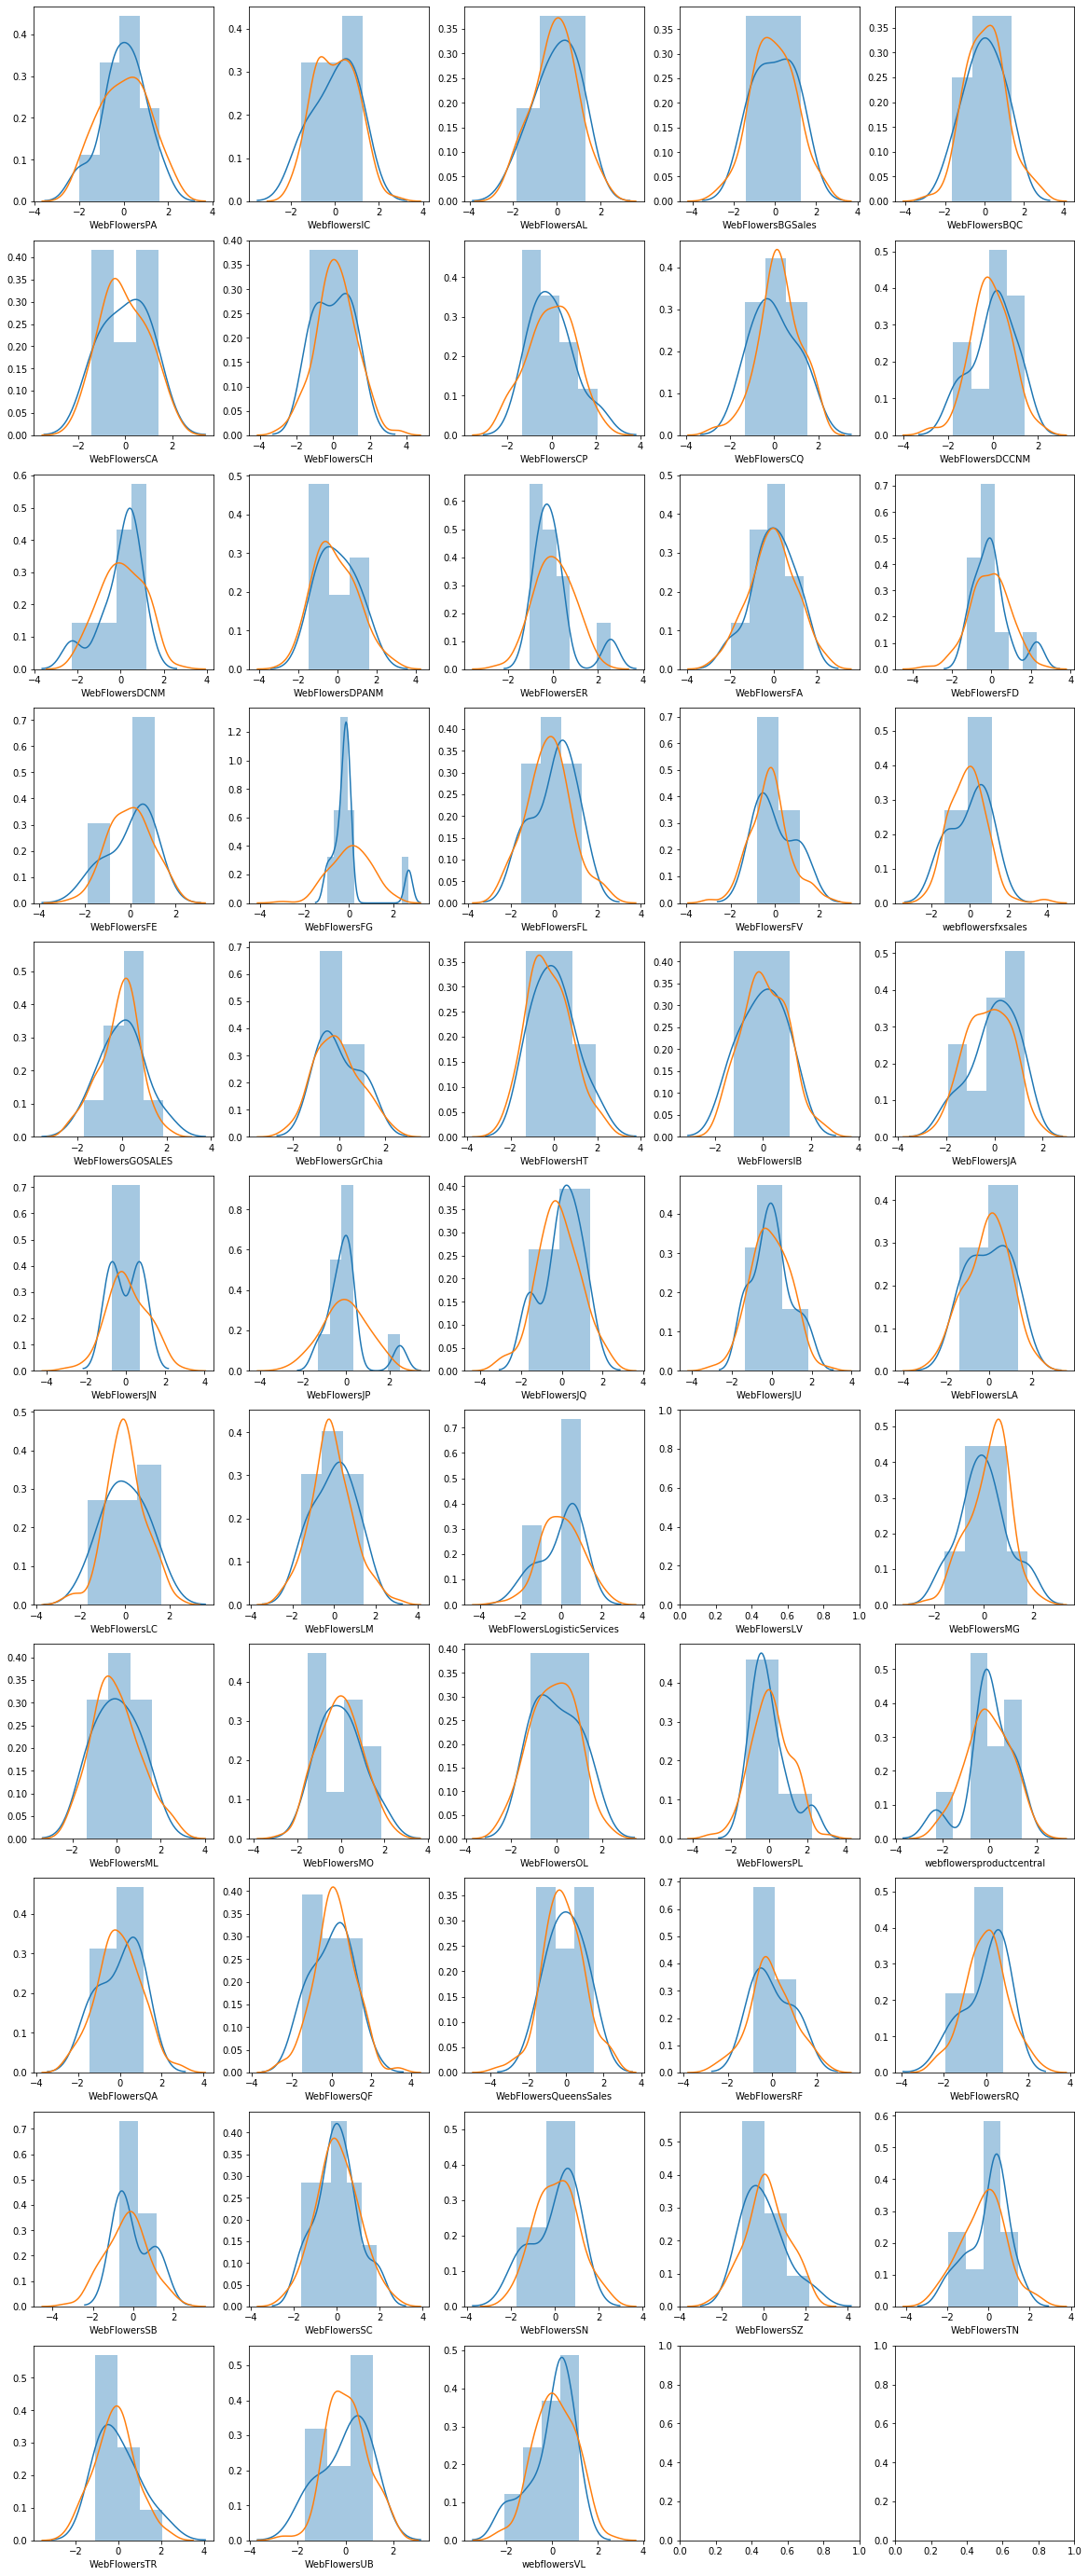

In [289]:
fig, axs = plt.subplots(11,5,figsize=(20,50))
for r in np.arange(0,11):
    for c in np.arange(0,5):
        if(r*5+c < 53):
            company = assets.Name[r*5+c]
            axs[r][c].set_xlabel(company)
            if(len(acumulados[company]['acumulado'])>1):
                m = acumulados[company].describe()['acumulado']['mean']
                s = acumulados[company].describe()['acumulado']['std']
                data=acumulados[company].apply(lambda x: (x.acumulado-m)/s,axis=1)
                normal = np.random.normal(size=100)
                sns.distplot(data,ax=axs[r][c],axlabel=False)
                sns.distplot(normal, hist=False,ax=axs[r][c])

## Prueba de Contrastes de Tukey

In [302]:
totalizadoDia =  totalizadoDia.dropna(axis=0,how='any')
t = totalizadoDia.transpose()
data_temp = np.array([])
groups = np.array([])

for i,r in assets.iterrows():
    if r.Name in t:
        x = np.array(t[r.Name][:-1])/math.pow(1024,3)
        data_temp = np.append(data_temp,x)
        groups = np.append(groups, np.repeat(r.Name,len(x)))

In [291]:
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(data_temp,groups=groups)
tk = mc.tukeyhsd(alpha=0.05)
tk.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
WebFlowersAL,WebFlowersCA,0.0776,0.9,-0.3402,0.4954,False
WebFlowersAL,WebFlowersCH,-0.0253,0.9,-0.4431,0.3925,False
WebFlowersAL,WebFlowersCP,0.0608,0.9,-0.357,0.4786,False
WebFlowersAL,WebFlowersCQ,-0.0103,0.9,-0.4281,0.4075,False
WebFlowersAL,WebFlowersDCCNM,-0.0927,0.9,-0.5105,0.3251,False
WebFlowersAL,WebFlowersDCNM,0.5939,0.001,0.1761,1.0117,True
WebFlowersAL,WebFlowersDPANM,0.041,0.9,-0.3768,0.4588,False
WebFlowersAL,WebFlowersER,0.1191,0.9,-0.2987,0.5369,False
WebFlowersAL,WebFlowersFA,-0.0569,0.9,-0.4747,0.3609,False
WebFlowersAL,WebFlowersFD,0.0417,0.9,-0.3761,0.4595,False


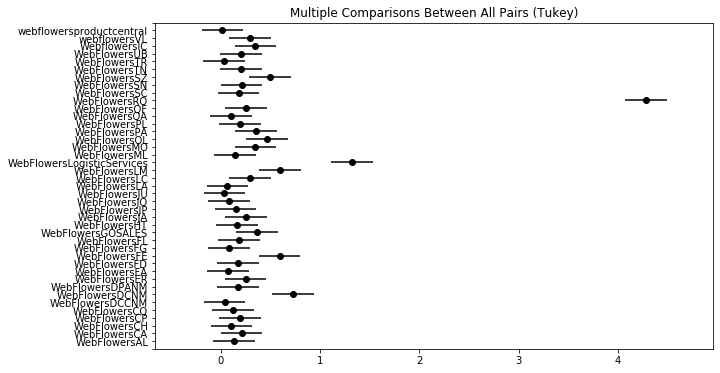

In [292]:
tk.plot_simultaneous();

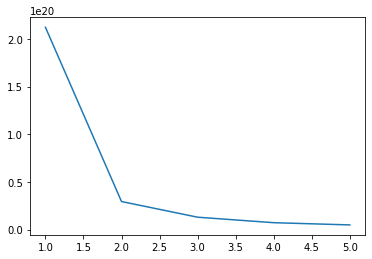

In [335]:
from sklearn.cluster import KMeans

wss=[]
for i in range(1,6):
    clus = KMeans(n_clusters=i,init='k-means++')
    clus.fit(totalizadoDia)
    wss.append(clus.inertia_)

plt.plot(range(1,6),wss)

In [280]:
from sklearn.cluster import KMeans

In [281]:
y_pred = KMeans(n_clusters=3,init='k-means++').fit_predict(totalizadoDia)

In [319]:
totalizadoDia['Grupo'] = y_pred
totalizadoDia.sample(10)

,0,1,2,3,4,5,6,7,8,9,Grupo
WebFlowersJU,23438623.0,4.790122e+07,57906418.0,42709781.0,23274785.0,35649013.0,66658710.0,40074147.0,45429015.0,35780998.0,0
WebFlowersSZ,709645979.0,1.023986e+09,543141952.0,660311339.0,267051323.0,287265235.0,434238749.0,493619393.0,389198517.0,287451019.0,2
WebFlowersFE,428404889.0,8.807344e+08,686552130.0,682527434.0,260906319.0,418459744.0,771316780.0,798028985.0,828577727.0,784059643.0,2
WebFlowersJP,126364703.0,1.682351e+08,144801910.0,181226658.0,73037726.0,113291262.0,152613283.0,174619586.0,340956586.0,176539466.0,0
WebFlowersJA,141427707.0,4.079678e+08,293247310.0,249776038.0,59161686.0,395016967.0,351040620.0,262827297.0,332505836.0,223134538.0,0
WebFlowersDCCNM,42488830.0,4.280466e+07,65321250.0,19229742.0,42531567.0,45211470.0,31467093.0,60920289.0,54100005.0,10957188.0,0
WebFlowersML,72928888.0,1.421906e+08,139768295.0,203638322.0,98542172.0,235725292.0,201382851.0,170429806.0,135590645.0,75055814.0,0
WebFlowersUB,35660013.0,3.523606e+08,316792886.0,263015286.0,71266612.0,120967907.0,284414839.0,337091962.0,226135836.0,238199994.0,0
WebFlowersMO,42761657.0,3.109517e+08,571693094.0,745106193.0,217820126.0,200004241.0,450400705.0,447393195.0,409519598.0,190814999.0,0
webflowersproductcentral,23335836.0,1.695744e+07,17692738.0,22691712.0,18019967.0,18639268.0,25436239.0,16633076.0,16574343.0,6230829.0,0


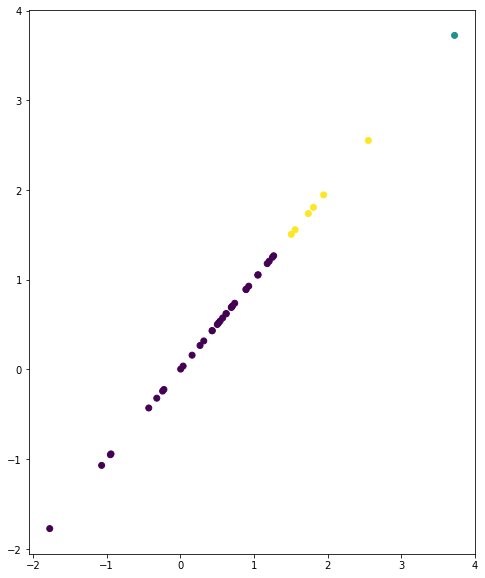

In [334]:
s=totalizadoDia.apply(np.sum,axis=1)/math.pow(1024,3)
s=np.log(s)
plt.figure(figsize=(8,10))
plt.scatter(s,s,c=y_pred);

In [324]:
len(totalizadoDia[totalizadoDia.Grupo==2])

6

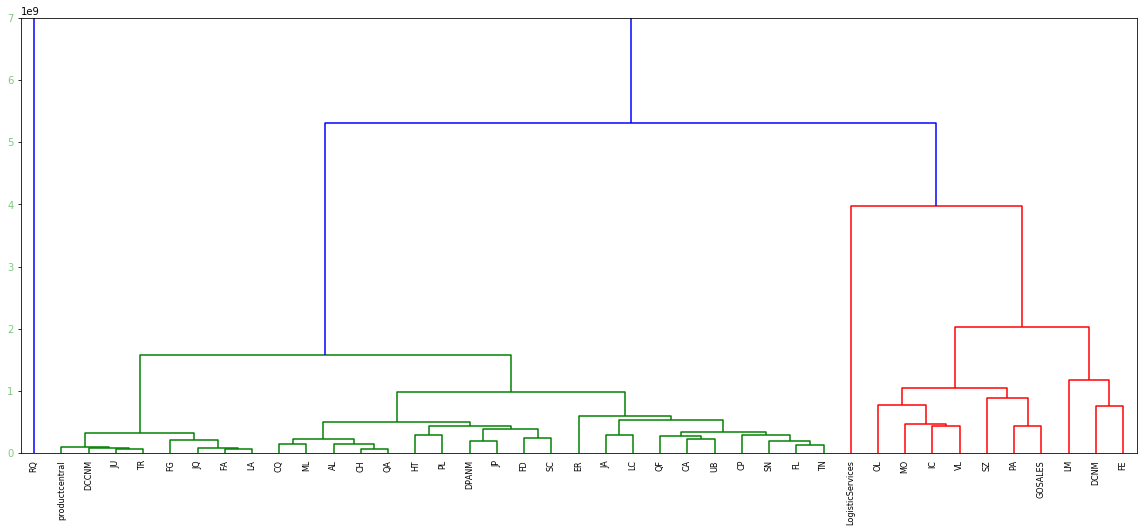

In [329]:
import scipy.cluster.hierarchy as shc
T=totalizadoDia.copy()
cat=np.array(pd.DataFrame(T.index)[0].apply(lambda c: c[10:]))
T.index=cat
Z = shc.linkage(T,'ward')
plt.figure(figsize=(20,8))
shc.dendrogram(Z, labels=T.index, leaf_rotation=90, orientation="top", color_threshold=0.4e10, above_threshold_color='blue');
palette = plt.cm.get_cmap("Accent", 3)
T['Grupo']=pd.Categorical(T['Grupo'])
colors=T['Grupo'].cat.codes
ax = plt.gca()
plt.ylim(0,0.7e10)
plt.yscale('linear')
xlbls = ax.get_ymajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    val=colors[num]
    lbl.set_color(palette(val))

In [330]:
Z

array([[2.10000000e+01, 3.80000000e+01, 5.89092476e+07, 2.00000000e+00],
       [1.10000000e+01, 2.20000000e+01, 6.10318416e+07, 2.00000000e+00],
       [4.00000000e+00, 3.10000000e+01, 6.80317958e+07, 2.00000000e+00],
       [7.00000000e+00, 4.10000000e+01, 7.54476516e+07, 3.00000000e+00],
       [2.00000000e+01, 4.20000000e+01, 8.16456321e+07, 3.00000000e+00],
       [3.00000000e+01, 4.40000000e+01, 9.63350795e+07, 4.00000000e+00],
       [1.50000000e+01, 3.70000000e+01, 1.21742439e+08, 2.00000000e+00],
       [6.00000000e+00, 2.60000000e+01, 1.42612398e+08, 2.00000000e+00],
       [2.00000000e+00, 4.30000000e+01, 1.51596517e+08, 3.00000000e+00],
       [9.00000000e+00, 1.90000000e+01, 1.84585348e+08, 2.00000000e+00],
       [3.50000000e+01, 4.70000000e+01, 1.95750834e+08, 3.00000000e+00],
       [1.40000000e+01, 4.50000000e+01, 2.08635825e+08, 4.00000000e+00],
       [3.00000000e+00, 3.90000000e+01, 2.16735463e+08, 2.00000000e+00],
       [4.80000000e+01, 4.90000000e+01, 2.25517582e

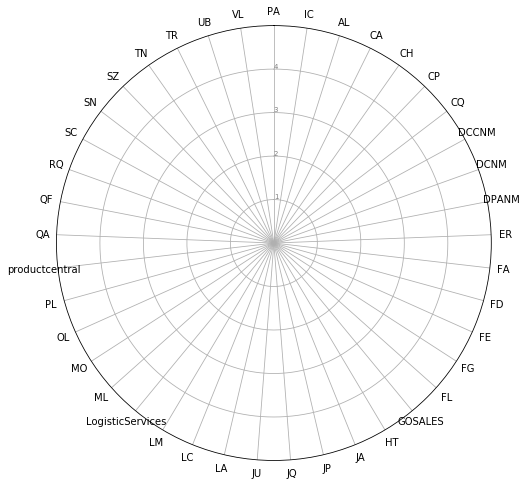

In [228]:
cat=np.array(pd.DataFrame(totalizadoDia.index)[0].apply(lambda c: c[10:]))
N = len(cat)
angles = [n/float(N)*2* math.pi for n in range(N)]
angles+=angles[:1]
plt.figure(figsize=(8,8))
ax=plt.subplot(111,polar=True)
ax.set_theta_offset(math.pi/2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1],cat);
ax.set_rlabel_position(0)
plt.yticks([1,2,3,4], ["1","2","3","4"], color="grey", size=7)
plt.ylim(0,5);
